# Matrix Product State (One dimensional Tensor Network) for the TMaze




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lib.UnsupGenModbyMPS.MPScumulant import MPS_c


## Data Loading and Preprocessing

In [2]:
#Load the data 

#XOR
entangled = np.array([[0, 0, 1],
                      [0, 1, 0],
                      [1, 0, 0],
                      [1, 1, 1]], dtype=np.float32)

# Two fair coins and an unfair one (all independent)
unentangled = np.array([[0, 0, 0],
                        [0, 1, 0],
                        [1, 0, 0],
                        [1, 1, 0]], dtype=np.float32)

X = unentangled

# Print basic information about the dataset
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")


Number of samples: 4
Number of features: 3


## Train MPS Model

bond: 0
bond: 1
bond: 1
Bondim 2->2
Current loss: 4.094280252053097
bond: 0
Bondim 2->2
Current loss: 3.64436606447015
Current Loss: 3.644366064
Bondim:
[2 2 1]
bond: 1
Bondim 2->2
bond: 0
Bondim 2->2
Current loss: 3.1219711389487443
Current Loss: 3.121971139
Bondim:
[2 2 1]
Training failed with error: list index out of range
Try adiusting batch size or learning rate


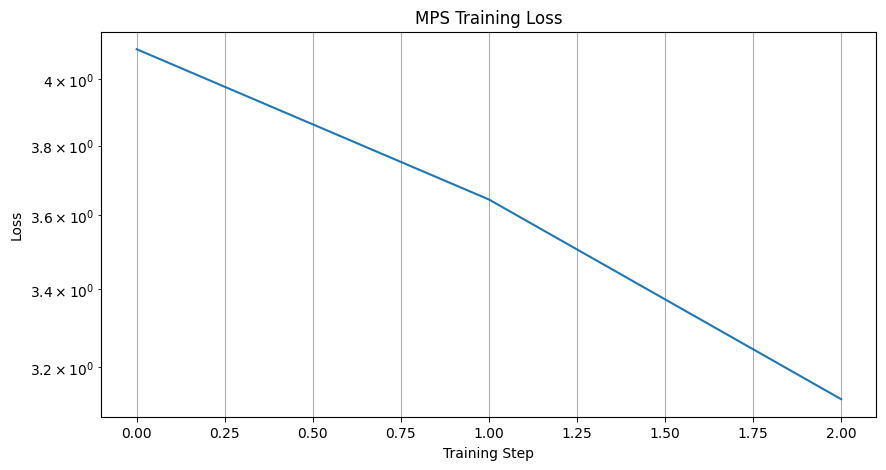

In [3]:
# Initialize MPS
n_features = X.shape[1]
mps = MPS_c(space_size=n_features)

# Configure training with more conservative parameters
mps.cutoff = 0.001  # Reduced from 0.01
mps.descenting_step_length = 0.001  # LEARNING RATE
mps.descent_steps = 10  # Reduced from 20
mps.nbatch = 4  # Use full-batch training (size of dataset)

# Train
mps.designate_data(X)
mps.left_cano()
mps.init_cumulants()
n_epochs = 2 # Reduced from 5

# Train with error handling
try:
    mps.train(n_epochs)
except Exception as e:
    print(f"Training failed with error: {str(e)}")
    print("Try adiusting batch size or learning rate")

# Plot training loss if available
if hasattr(mps, 'Loss') and len(mps.Loss) > 0:
    plt.figure(figsize=(10, 5))
    plt.plot(mps.Loss)
    plt.title('MPS Training Loss')
    plt.xlabel('Training Step')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.grid(True)
    plt.show()

## Analyze MPS Structure

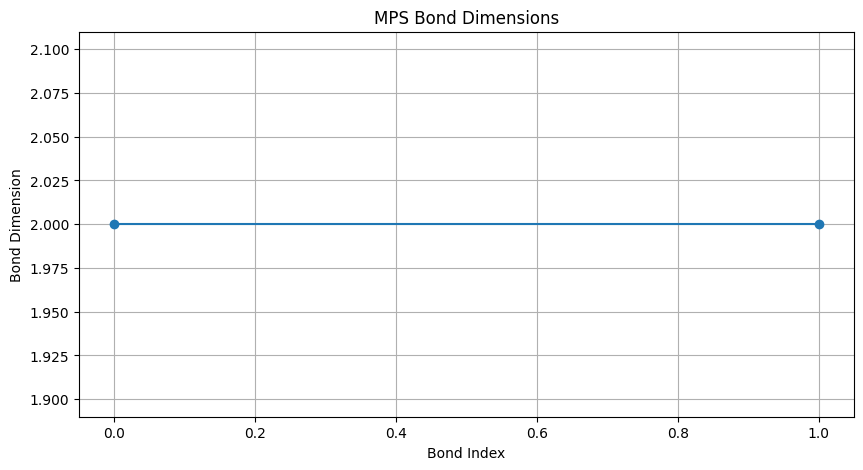

Total number of elements in dataset: 12
Total number of elements in all tensors: 24
Compression percentage: -100.00%


In [4]:
# Plot bond dimensions
plt.figure(figsize=(10, 5))
plt.plot(mps.bond_dimension[:-1], 'o-')
plt.title('MPS Bond Dimensions')
plt.xlabel('Bond Index')
plt.ylabel('Bond Dimension')
plt.grid(True)
plt.show()

def total_tensor_elements_from_bond_dimensions(bond_dimensions):
    """Calculate the total number of elements in all tensors based on bond dimensions."""
    total_elements = 0
    for i in range(len(bond_dimensions) - 1):
        total_elements += bond_dimensions[i] * bond_dimensions[i + 1] 
    return total_elements * 2 * 2  # Multiply by 2 for complex numbers and 2 for physical dimension
                                    # Assuming physical dimension is 2 (for binary features)

# Example usage
total_elements = total_tensor_elements_from_bond_dimensions(mps.bond_dimension)
print(f"Total number of elements in dataset: {X.shape[0] * X.shape[1]}")
print(f"Total number of elements in all tensors: {total_elements}")
# compressed by how much percetnage
compression_percentage = 100 * (1 - total_elements / (X.shape[0] * X.shape[1]))
print(f"Compression percentage: {compression_percentage:.2f}%")

## Extract Entanglement to derive explanations


In [ ]:
import tensornetwork as tn
def tensorNet(mps):

    mps.right_cano() # Use right-canonical form
    # Convert MPS to TensorNetwork
    nodes = []
    conj_nodes = []
    for idx, tensor in enumerate(mps.matrices):
        nodes.append(tn.Node(tensor, name=f"node_{idx}"))
        conj_nodes.append(tn.Node(np.conj(tensor), name=f"conj_node_{idx}"))

    return nodes, conj_nodes

### Ensure Normalization


In [6]:
nodes, conj_nodes = tensorNet(mps)
all_nodes = nodes + conj_nodes

# 1. Connect uninformative edges
nodes[0][0] ^ conj_nodes[0][0]
nodes[-1][2] ^ conj_nodes[-1][2]

# Connect physical edges
for i in range(len(nodes)):
    tn.connect(nodes[i][1], conj_nodes[i][1])  # Connect physical edges

# Connect virtual edges
for i in range(len(nodes) - 1):
    tn.connect(nodes[i][2], nodes[i + 1][0])  # Connect right edge of node i to left edge of node i+1
    tn.connect(conj_nodes[i][2], conj_nodes[i + 1][0])  # Same for conjugate nodes

final_node = tn.contractors.auto(all_nodes)
norm = final_node.tensor
print("Normalization check (should be close to 1):", norm)

bond: 1
Normalization check (should be close to 1): 0.9999999999999993


In [7]:
def von_neumann_entropy(rho):
    """Computes the von Neumann entropy of a density matrix."""
    # Filter out zero eigenvalues to avoid log(0)
    eigenvalues = np.linalg.eigvalsh(rho)
    non_zero_eigenvalues = eigenvalues[eigenvalues > 1e-12]
    return -np.sum(non_zero_eigenvalues * np.log2(non_zero_eigenvalues))

def get_rdm(nodes, conj_nodes, sites):
    """
    Computes the reduced density matrix (RDM) for a given set of (ascending) sites.
    """

    print("\n \n Initial sites:", sites)

    # Due to left-canonicalization, we only need to contract up to the rightmost site.
    max_site = max(sites)
    nodes = nodes[:max_site + 1]
    conj_nodes = conj_nodes[:max_site + 1]
    #print("\n Nodes1:", nodes)

    # 1. Connect uninformative edges
    nodes[0][0] ^ conj_nodes[0][0]
    #nodes[-1][2] ^ conj_nodes[-1][2]

    # 2. Connect the virtual "bond" indices of the MPS chain
    for i in range(max_site):
        nodes[i][2] ^ nodes[i+1][0]
        conj_nodes[i][2] ^ conj_nodes[i+1][0]

    # Define the open edges for the RDM
    open_edges = []
    for site_idx in sites:
        open_edges.append(nodes[site_idx][1])
    for site_idx in sites:
        open_edges.append(conj_nodes[site_idx][1])

    # Create a list of sites to be contracted (traced out)
    sites_to_contract = set(range(max_site + 1)) - sites

    # 3. Connect the physical indices of the sites to be traced out
    for i in sites_to_contract:
        nodes[i][1] ^ conj_nodes[i][1]


    # Contract the network to get the RDM tensor
    rdm_node = tn.contractors.auto(nodes + conj_nodes, output_edge_order=open_edges)
    rdm_tensor = rdm_node.tensor

    # Multiply the first half of the shape vector to get the matrix dimensions
    rdm_rows = int(np.prod(rdm_tensor.shape[:len(rdm_tensor.shape)//2]))
    print("\n RDM tensor shape:", rdm_tensor.shape)

    # Reshape into a matrix
    rdm = rdm_tensor.reshape(rdm_rows, rdm_rows)

    return rdm


In [8]:
# Calculate single-site entropies first
single_site_entropies = []
for i in range(n_features):
    nodes, conj_nodes = tensorNet(mps)
    rho_i = get_rdm(nodes, conj_nodes, {i})
    print("\n RDM for site", i, ":\n", rho_i)
    s_i = von_neumann_entropy(rho_i)
    single_site_entropies.append(s_i)

# Initialize a matrix to store mutual information
mi_matrix = np.zeros((n_features, n_features))

# Iterate over all unique pairs of features
for i in range(n_features):
    for j in range(i + 1, n_features):
        # Get single site entropies
        s_i = single_site_entropies[i]
        s_j = single_site_entropies[j]
        
        # Get joint RDM and compute joint entropy
        rho_ij = get_rdm(nodes, conj_nodes, {i, j})
        s_ij = von_neumann_entropy(rho_ij)
        
        # Compute mutual information: I(i,j) = S(i) + S(j) - S(i,j)
        mi = s_i + s_j - s_ij
        print(s_i, s_j, s_ij, mi)
        mi_matrix[i, j] = mi
        mi_matrix[j, i] = mi # MI is symmetric

print("Mutual Information Matrix:")
print(mi_matrix)

# Plot the MI matrix as a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(mi_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Mutual Information')
plt.title('Pairwise Mutual Information')
plt.xlabel('Feature Index')
plt.ylabel('Feature Index')
plt.xticks(np.arange(n_features))
plt.yticks(np.arange(n_features))


 
 Initial sites: {0}


ValueError: output edges are not equal to the remaining non-contracted edges of the final node.